In [1]:
import matplotlib.pyplot as plt
from AaltoAtoms import CircCorralData, CircCorral
from AaltoAtoms import get_perfect_circle_positions, minimize_manipulation_distance, lattice_discretize
from AMRL import Createc_Controller
from AMRL.Environment.get_atom_coordinate import pixel_to_nm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import ipywidgets as wdg

## Get scan from STM, get atom positions, program lateral manipulations (in order of labeling in figure) using GUI. 
This may require fine-tuning parameters 'percentile' and 'edge_cutoff' in the C.get_region_centroids() call until only surface features you want to see are registered in the image frame when you run the cell.

Left click to choose atom destination. Right click to 'cancel' the current atom (i.e. do not manipulate)

succeed to connect
	23 centroids


<IPython.core.display.Javascript object>


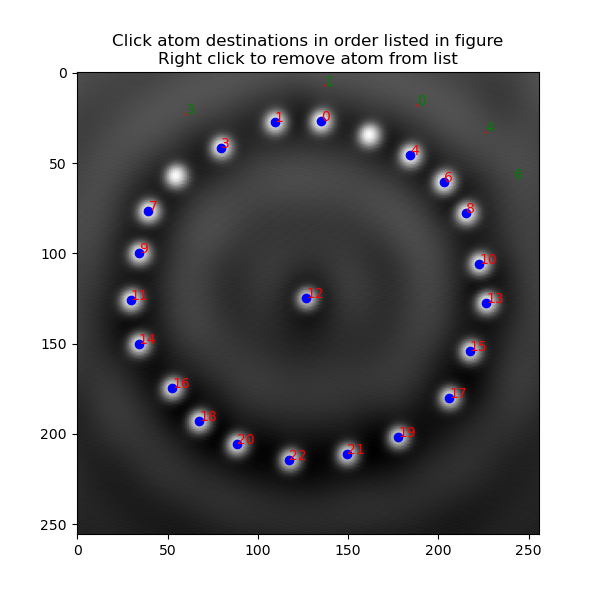

Textarea(value='[]', description='points:')

In [4]:
%matplotlib notebook
CC = Createc_Controller()

Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)

centroids = C.centroids

# scale numbers between 0 and 1
# the image has to have 3 channels
# in this case we will just repeat the same channel 3 times
im = MinMaxScaler().fit_transform(Cim.flatten().reshape(-1, 1)).reshape(Cim.shape)
dispmat = np.stack([im,im,im], axis=-1)

fig = plt.figure(figsize=(6,6))
plt.imshow(dispmat)
plt.show()
# show the atom positions
sctr = plt.scatter(*np.array(centroids).T, color="blue")

# give numbers to atom positions
centroids_text = []
for n, c in enumerate(centroids):
    t = plt.text(*c,'%d' %(n), color='r')
    centroids_text.append(t)

# List for selected pixels
selected = []
index = 0

# Create a text area for displaying selected pixels
text_area = wdg.Textarea(
    value = str(selected),
    description = "points:",
    disabled = False
)
display(text_area)

removed = 0

# Function to run when a pixel is clicked
def onclick(event):
    print(help(event))
    ''' Add the clicked pixel to the list of selected pixels and
    display it as red in the image.
    '''
    global selected
    global index
    global sctr
    global centroids
    global centroids_text
    global removed 
    
    x = int(event.xdata+0.5)
    y = int(event.ydata+0.5)
    
    # right click: 
    if event.button ==3:
        text_area.value = '%s click: button=%d' %('double' if event.dblclick else 'single', event.button)
        centroids.pop(index-removed)
        sctr.remove()
        centroids_text[index-removed].remove()
        centroids_text.pop(index-removed)
        plt.imshow(dispmat)
        sctr = plt.scatter(*np.array(centroids).T, color="blue")
        index += 1
        removed += 1
        return
    
    # left click: 
    if event.button == 1:

        if (y, x) in selected:
            im[y,x] = C.im[y,x]
            dispmat[y,x,:] = [im[y,x], im[y,x], im[y,x]]
            selected.remove((y, x))
        else:
            dispmat[y,x,:] = [1,0,0]
            selected += [(y, x)]
        text_area.value = str(selected)  # str(dir(event))
    
        
    print(selected)
    #plt.imshow(dispmat)
    plt.text(x,y,'%d' %(index), color='green')
    index += 1
    fig.canvas.draw()
plt.title("Click atom destinations in order listed in figure\nRight click to remove atom from list")
ka = fig.canvas.mpl_connect('button_press_event', onclick)

### Show atom positions from scan frame and programmed lateral manipulations. 
If they are wrong, run GUI notebook cell again and program lateral manipulations again using GUI.

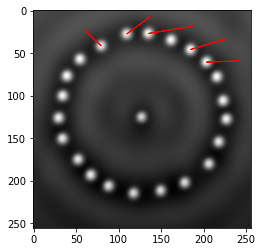

In [5]:
%matplotlib inline
#assert(len(selected)==len(C.centroids))
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()
selected1 = selected
n_selected = min([len(centroids), len(selected)])
for n, c in enumerate(centroids[0:n_selected]):
    plt.arrow(*c, *(np.array(list(reversed(selected1[n])))-np.array(c)), color="r")
plt.imshow(dispmat);
plt.show()

## Carry out lateral manipulations in order 

[134.9102564102564, 26.71794871794872] [186, 158]


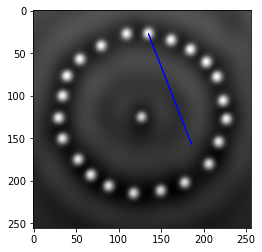

135 27 186 158


In [ ]:
# set lateral manipulation parameters
latman_millivolt = 3
latman_picoamp = 80000
scan_bias_mv = 1000

offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# for each "atom" in the image
for n in range(len(centroids[0:])):
    print(centroids[n], list(reversed(selected1[n])))
    initial = pixel_to_nm(centroids[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(list(reversed(selected1[n]))), dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids[n], *(np.array(list(reversed(selected[n])))-np.array(centroids[n])), color="blue")
    plt.show()
    
    # see documentation in AMRL/Environment/createc_control.py
    latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)
    
CC.ramp_bias_mV(scan_bias_mv)
CC.stm.scanstart()